In [1]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
  Using cached nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl (199.0 MB)


In [2]:
!pip install rdkit

  Using cached rdkit-2024.3.5-cp310-cp310-manylinux_2_28_x86_64.whl (33.1 MB)


In [3]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
  Using cached pyaml-24.7.0-py3-none-any.whl (24 kB)


In [4]:
!pip install --upgrade umap-learn

  Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)


In [5]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)


In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import os
from typing import Tuple

In [7]:
os. getcwd()

'/home/jovyan/Python_ML/PLD'

In [8]:
# Load data
activity = pd.read_csv('AND_cpds_PLD_v4.csv', delimiter=";")
#activity.head()

In [9]:
numcols = activity.columns[2:]

In [10]:

initial_df2 = activity.dropna()

### t-SNE plot

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Separate numcols columns and target variable (if any)
X = initial_df2[numcols]

# If you have a target variable (e.g., 'pIC50'), uncomment the following line:
y = initial_df2['Label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and fit t-SNE model
tsne_model = TSNE(n_components=2, random_state=1206, perplexity=30, n_iter=10000)
tsne_result = tsne_model.fit_transform(X_scaled)

# Create a new dataframe with t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['tSNE1', 'tSNE2'])

# If you have a target variable, add it to the t-SNE dataframe
tsne_df['Class'] = y




/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [12]:
# Visualize t-SNE results
#plt.figure(figsize=(12, 8))
#sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2',  hue='Class',palette='Set1')
#plt.title('t-SNE Projection of ErG fingeprint and Chemphys descriptors for PLD dataset')
#plt.show()

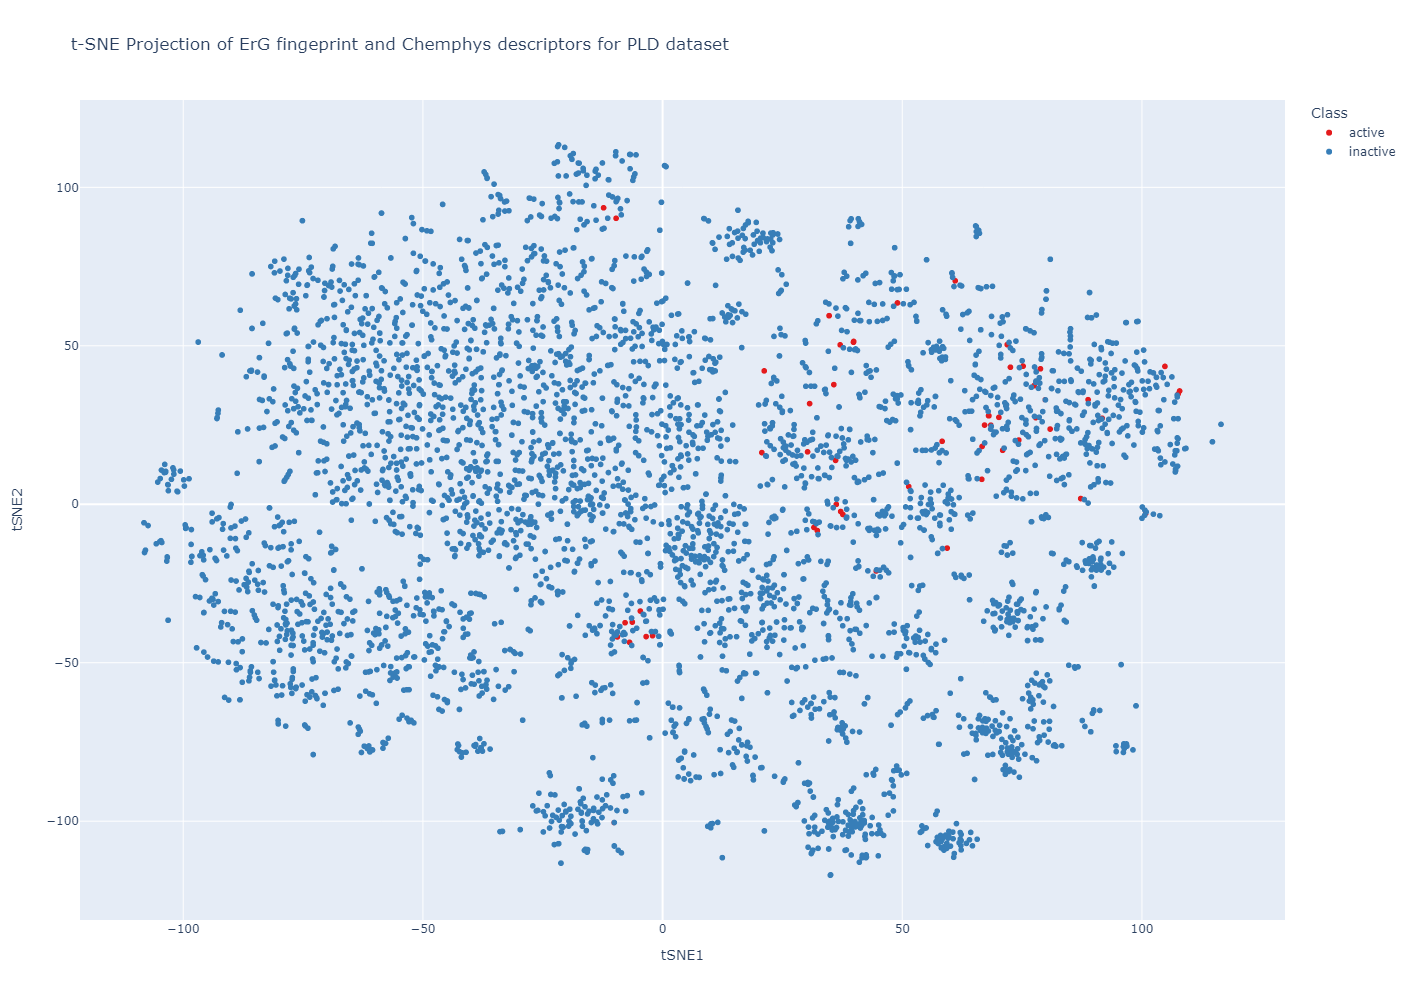

In [13]:
import plotly.express as px
import plotly as ply

fig = px.scatter(tsne_df, x='tSNE1', y='tSNE2', 
                 color='Class',
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 title='t-SNE Projection of ErG fingeprint and Chemphys descriptors for PLD dataset',
                 height=1000,  # Set the height of the plot
                 width=1200)  # Set the width of the plot
fig.show()

In [46]:
ply.offline.plot(fig, filename='PLD/PLD_tSNE.html')

'PLD/PLD_tSNE.html'

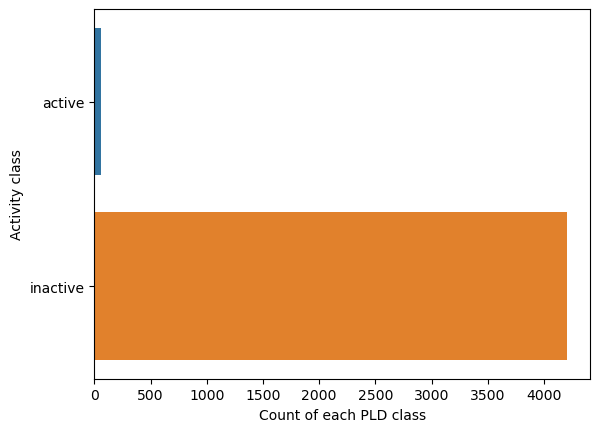

In [17]:
sns.countplot(y=initial_df2['Label'] ,data=initial_df2)
plt.xlabel("Count of each PLD class")
plt.ylabel("Activity class")
plt.show()

# Cohen's Kappa as custom metric

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score

def kappa_metric(y_true, y_pred):
    return 'kappa', cohen_kappa_score(y_true, y_pred.round())

class CustomXGBClassifier(XGBClassifier):
    def fit(self, X, y, **kwargs):
        custom_metric = kwargs.pop('custom_metric', None)
        eval_set = kwargs.get('eval_set', None)
        if custom_metric and eval_set:
            super().fit(X, y, **kwargs, callbacks=[custom_metric])
        else:
            super().fit(X, y, **kwargs)



In [28]:
# XGBoost
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Separate numcols columns and target variable (if any)
X = initial_df2[numcols]

# If you have a target variable (e.g., 'pIC50'), uncomment the following line:
y = initial_df2['Label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, label_encoded_y, test_size=0.2, random_state=42)

default_model = CustomXGBClassifier(
    objective='binary:logistic',
    #num_class=2,
    n_estimators=500,
    #use_label_encoder=True,
    eval_metric='auc',
    #custom_metric = "kappa_metric"
)

default_model.fit(X_train, y_train)

y_pred = default_model.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.98      1.00      0.99       836

    accuracy                           0.98       852
   macro avg       0.79      0.59      0.64       852
weighted avg       0.98      0.98      0.98       852



# SMOTE rebalancing

In [35]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 3364, 0: 3364})


In [36]:
default_model = xgb.XGBClassifier(
    objective='binary:logistic',
    #num_class=2,
    n_estimators=500,
    #use_label_encoder=True,
    eval_metric='auc'
)

default_model.fit(X_res, y_res)

y_pred = default_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.25      0.36        16
           1       0.99      1.00      0.99       836

    accuracy                           0.98       852
   macro avg       0.83      0.62      0.68       852
weighted avg       0.98      0.98      0.98       852



In [37]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [700],
    'learning_rate': [0.025, 0.05],
    'max_depth': [8, 10],
    'gamma': [0, 1],
    'colsample_bytree': [0.5],
    'min_child_weight': [2, 3, 5],
    'subsample': [1]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='auc'), #use_label_encoder=False,),
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_res, y_res)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 700, 'subsample': 1}


In [38]:
# Final model
final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    objective='binary:logistic',
    #num_class=len(y.unique()),
    #scale_pos_weight=0.5,
    #use_label_encoder=False,
    eval_metric='auc'
)

final_model.fit(X_res, y_res) #using SMOTE
#final_model.fit(X_train, y_train)

# Evaluate
y_pred_train = final_model.predict(X_res)
y_pred_test = final_model.predict(X_test)

print("Train set performance:")
print(classification_report(y_test, y_pred_test))

Train set performance:
              precision    recall  f1-score   support

           0       0.71      0.31      0.43        16
           1       0.99      1.00      0.99       836

    accuracy                           0.98       852
   macro avg       0.85      0.66      0.71       852
weighted avg       0.98      0.98      0.98       852



In [46]:
import pickle
with open('final_model_PLD_XGBoost.pkl', 'rb') as f:
    final_model_old = pickle.load(f)

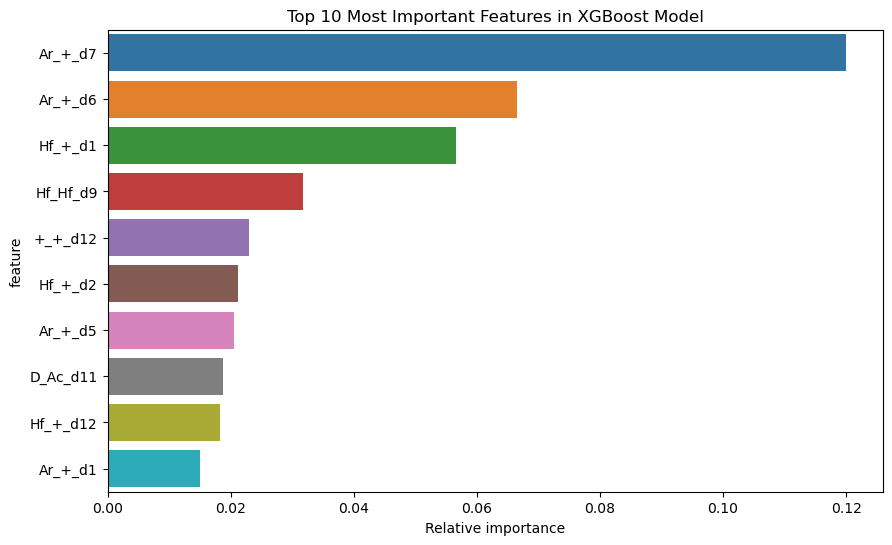

      feature  importance
126   Ar_+_d7    0.119900
125   Ar_+_d6    0.066512
45    Hf_+_d1    0.056633
8    Hf_Hf_d9    0.031761
236   +_+_d12    0.022942
46    Hf_+_d2    0.021166
124   Ar_+_d5    0.020530
205  D_Ac_d11    0.018835
56   Hf_+_d12    0.018241
120   Ar_+_d1    0.015069


In [47]:
# Feature importance
importance = final_model_old.feature_importances_
feature_importance = pd.DataFrame({'feature': initial_df2.columns[2:], 'importance': importance})
#feature_importance = pd.DataFrame({'feature': X_test.columns, 'importance': importance})
#feature_importance = pd.DataFrame({'feature': numcols, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Most Important Features in XGBoost Model')
plt.xlabel("Relative importance")
plt.show()

print(feature_importance)

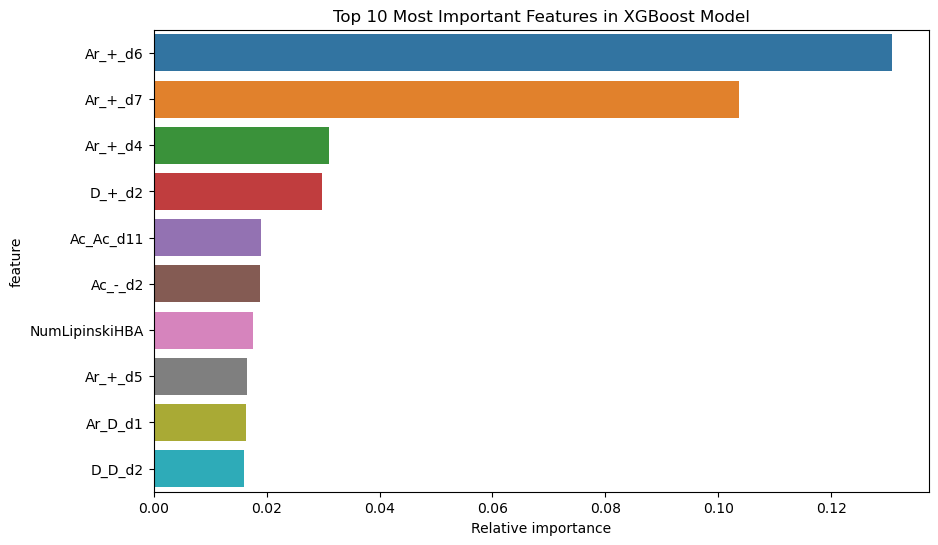

            feature  importance
125         Ar_+_d6    0.130717
126         Ar_+_d7    0.103625
123         Ar_+_d4    0.031124
181          D_+_d2    0.029772
280       Ac_Ac_d11    0.018938
286         Ac_-_d2    0.018786
321  NumLipinskiHBA    0.017523
124         Ar_+_d5    0.016604
105         Ar_D_d1    0.016296
166          D_D_d2    0.016010


In [44]:
# Feature importance
importance = final_model.feature_importances_
feature_importance = pd.DataFrame({'feature': initial_df2.columns[2:], 'importance': importance})
#feature_importance = pd.DataFrame({'feature': X_test.columns, 'importance': importance})
#feature_importance = pd.DataFrame({'feature': numcols, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Most Important Features in XGBoost Model')
plt.xlabel("Relative importance")
plt.show()

print(feature_importance)

In [57]:
import pickle

# Assuming you have trained your XGBoost model and it's called 'final_model'
with open('PLD/final_model_PLD_XGBoost.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)

In [59]:
# generation of external X_test (see above)

# Make predictions
predictions = final_model.predict(X_test)

print("Predictions:", predictions[:20])

Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/tmp/ipykernel_153/898737492.py:6: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



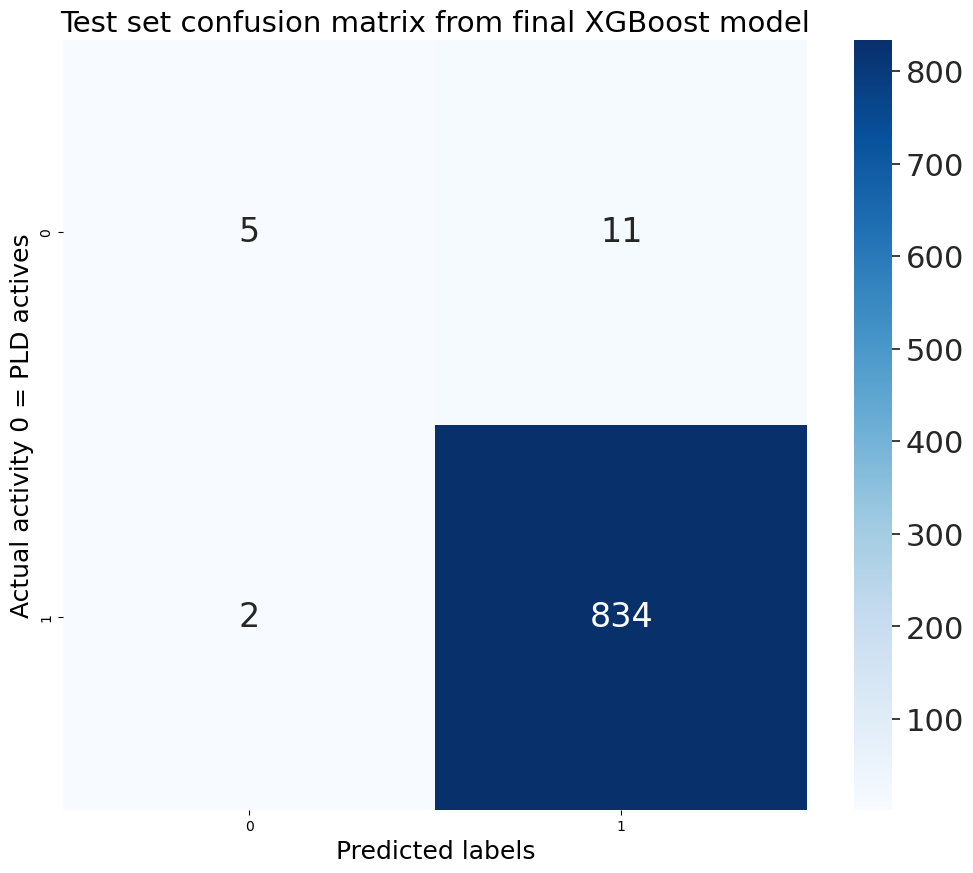

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

ax = plt.subplot()
sns.set(font_scale=2.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Actual activity 0 = PLD actives', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Test set confusion matrix from final XGBoost model', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['0', '1']);
ax.yaxis.set_ticklabels(['0', '1']);
plt.show()

In [36]:
top10cols = ['Ar_+_d7','Ar_+_d6','Hf_+_d1','Hf_Hf_d9','+_+_d12','Hf_+_d2','Ar_+_d5','D_Ac_d5','Hf_+_d12','Ar_+_d1']

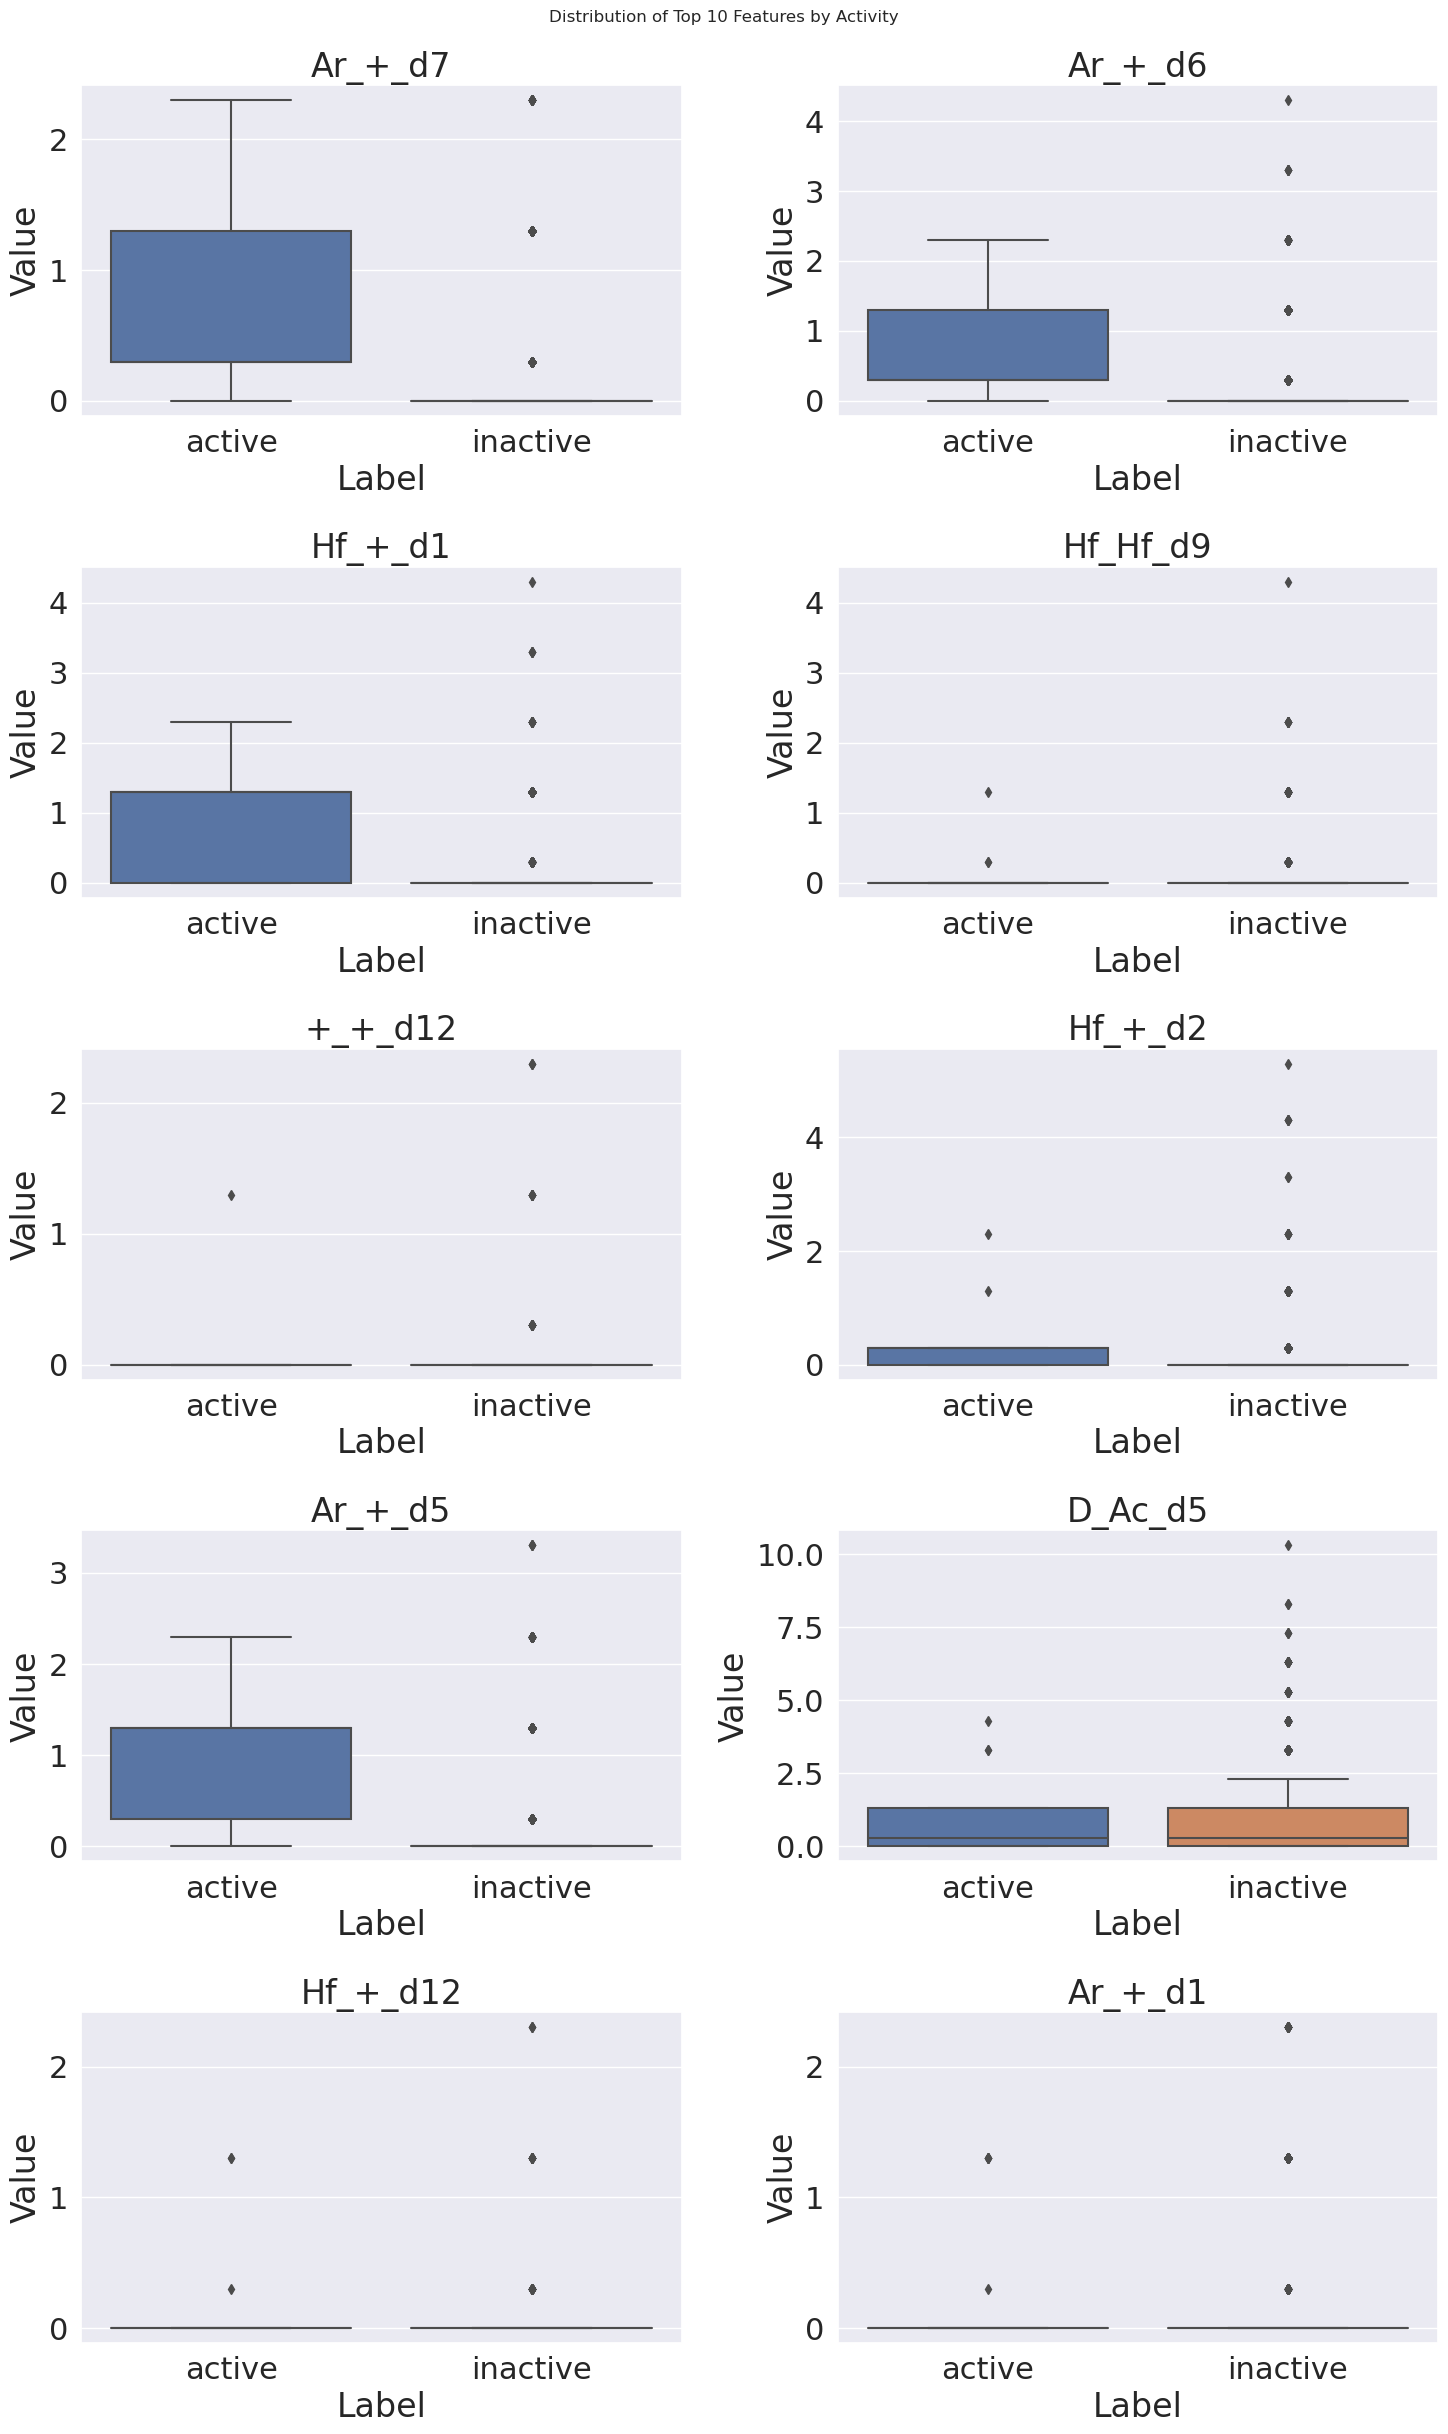

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your top10cols and initial_df2 dataframe

# Set up the plot
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Distribution of Top 10 Features by Activity', fontsize=12)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create a boxplot for each feature
for i, col in enumerate(top10cols):
    sns.boxplot(x='Label', y=col, data=initial_df2, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel('Value')

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

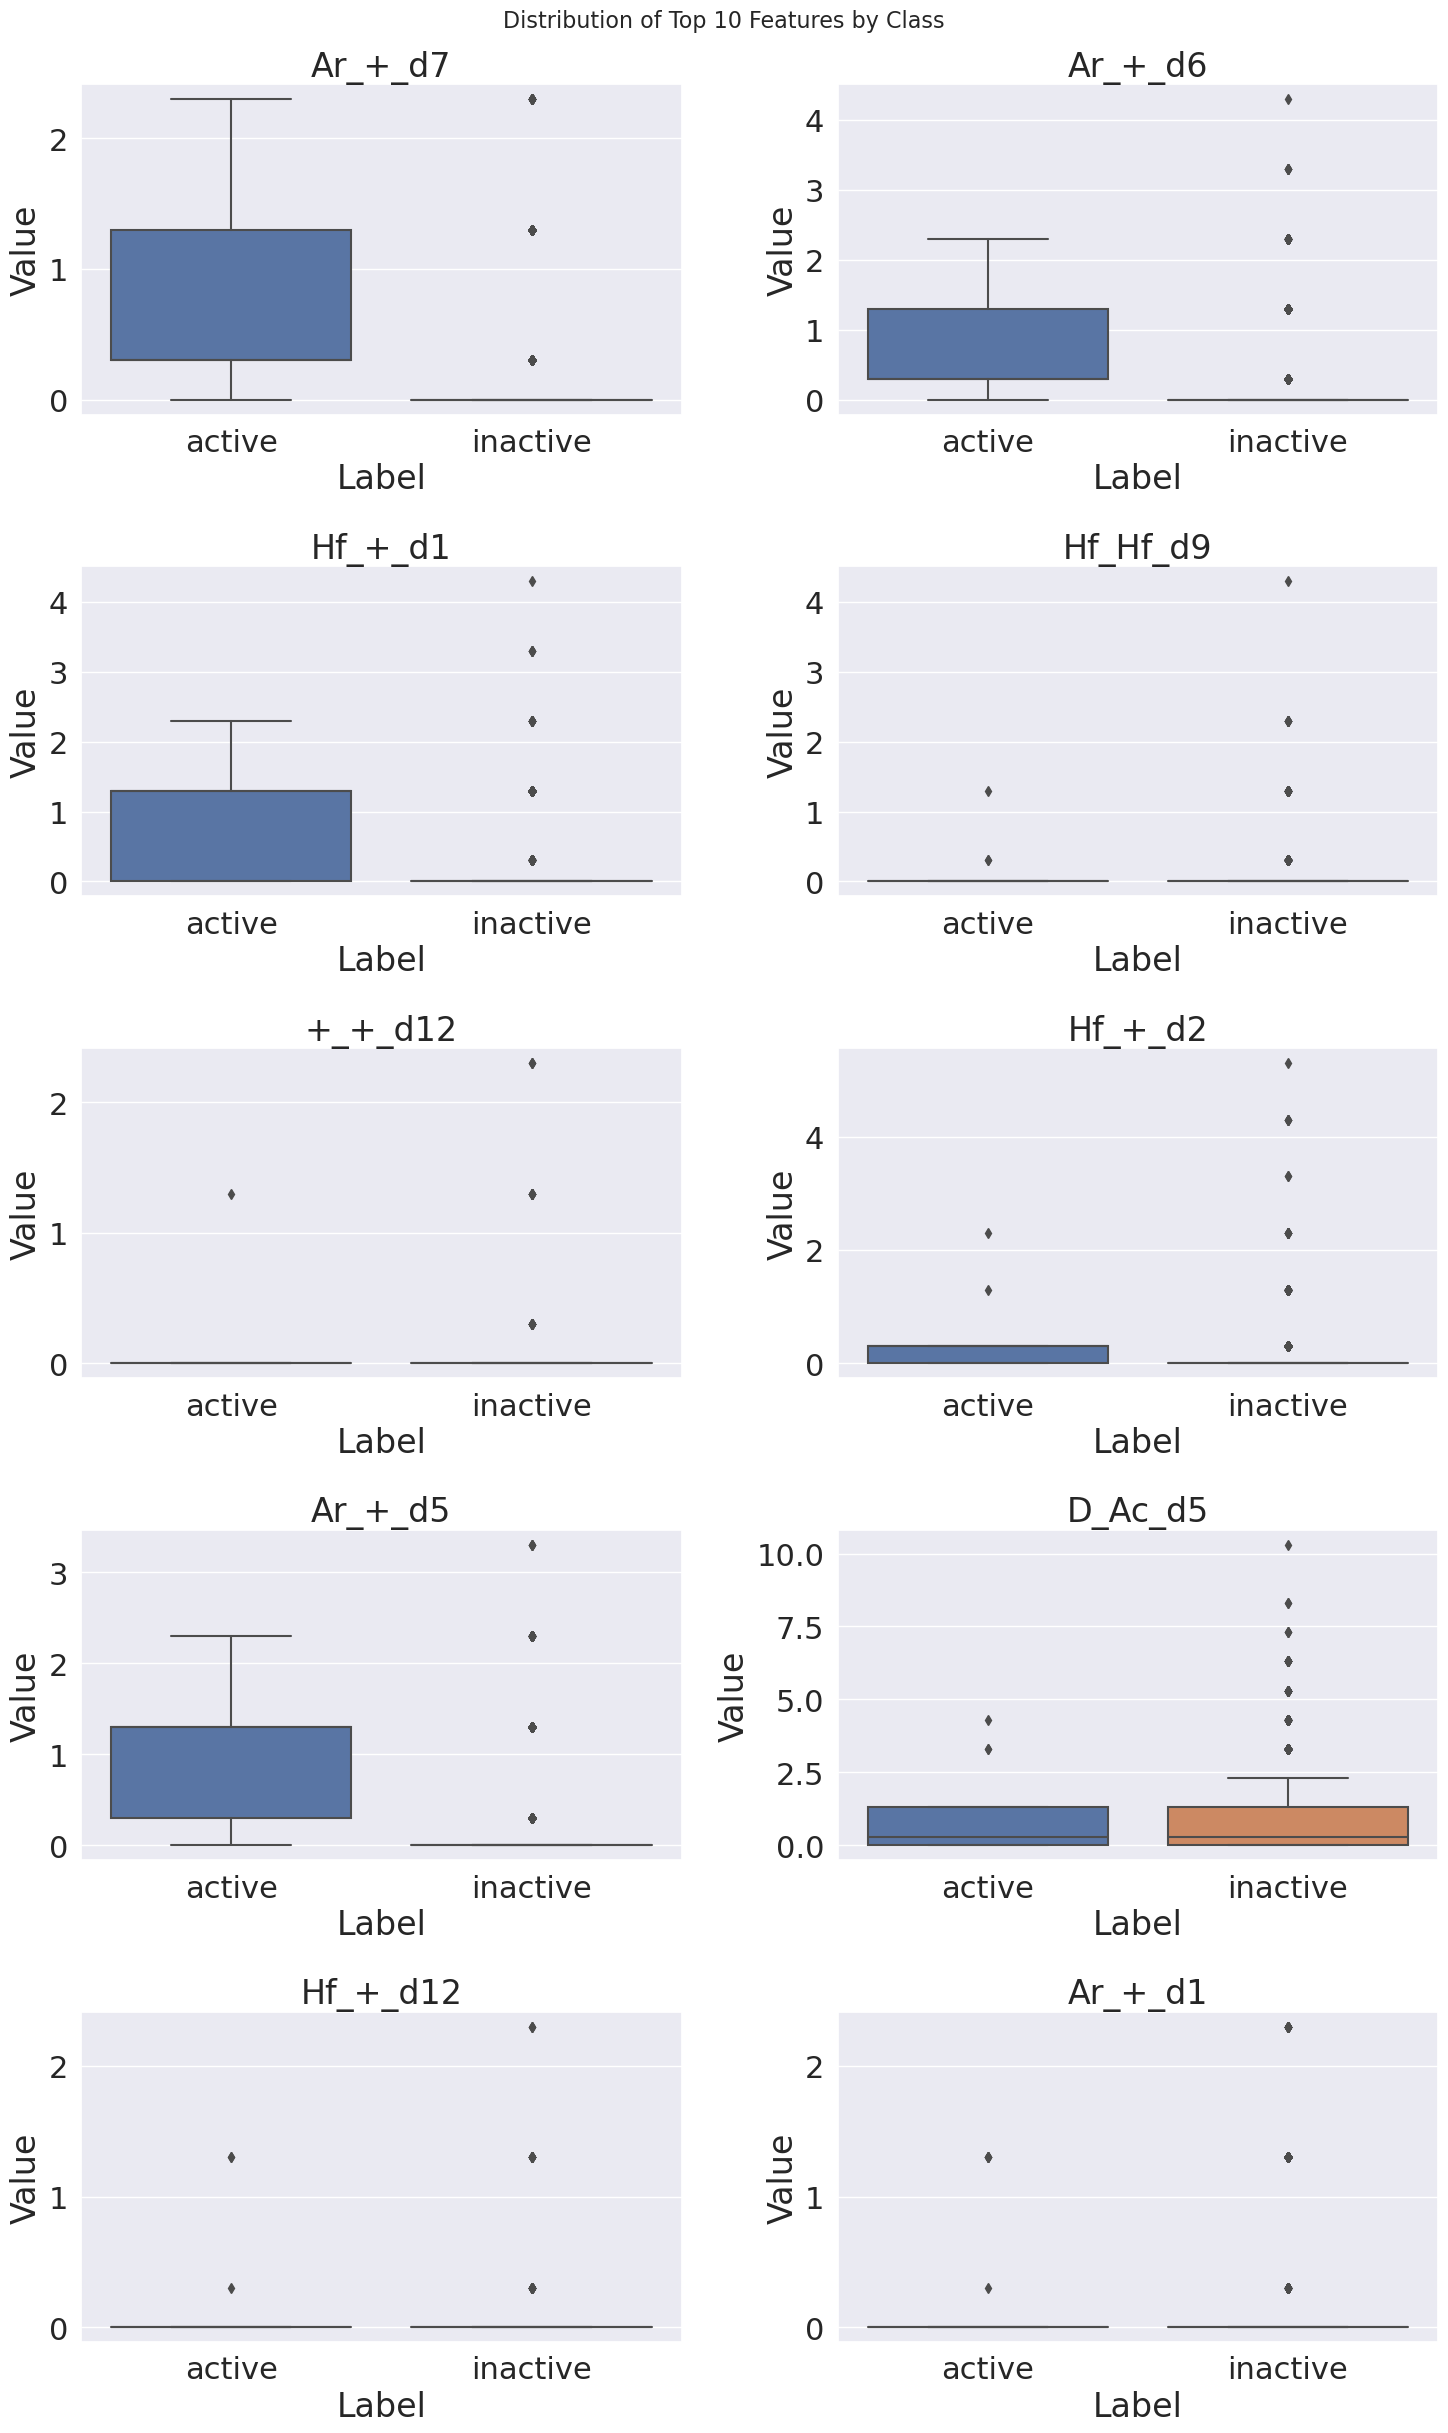

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your top10cols and initial_df2 dataframe

# Set up the plot
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Distribution of Top 10 Features by Class', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create a boxplot for each feature
for i, col in enumerate(top10cols):
    sns.boxplot(x='Label', y=col, data=initial_df2, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Save the figure as SVG
plt.savefig('top10_features_boxplots.svg', format='svg', dpi=600, bbox_inches='tight')


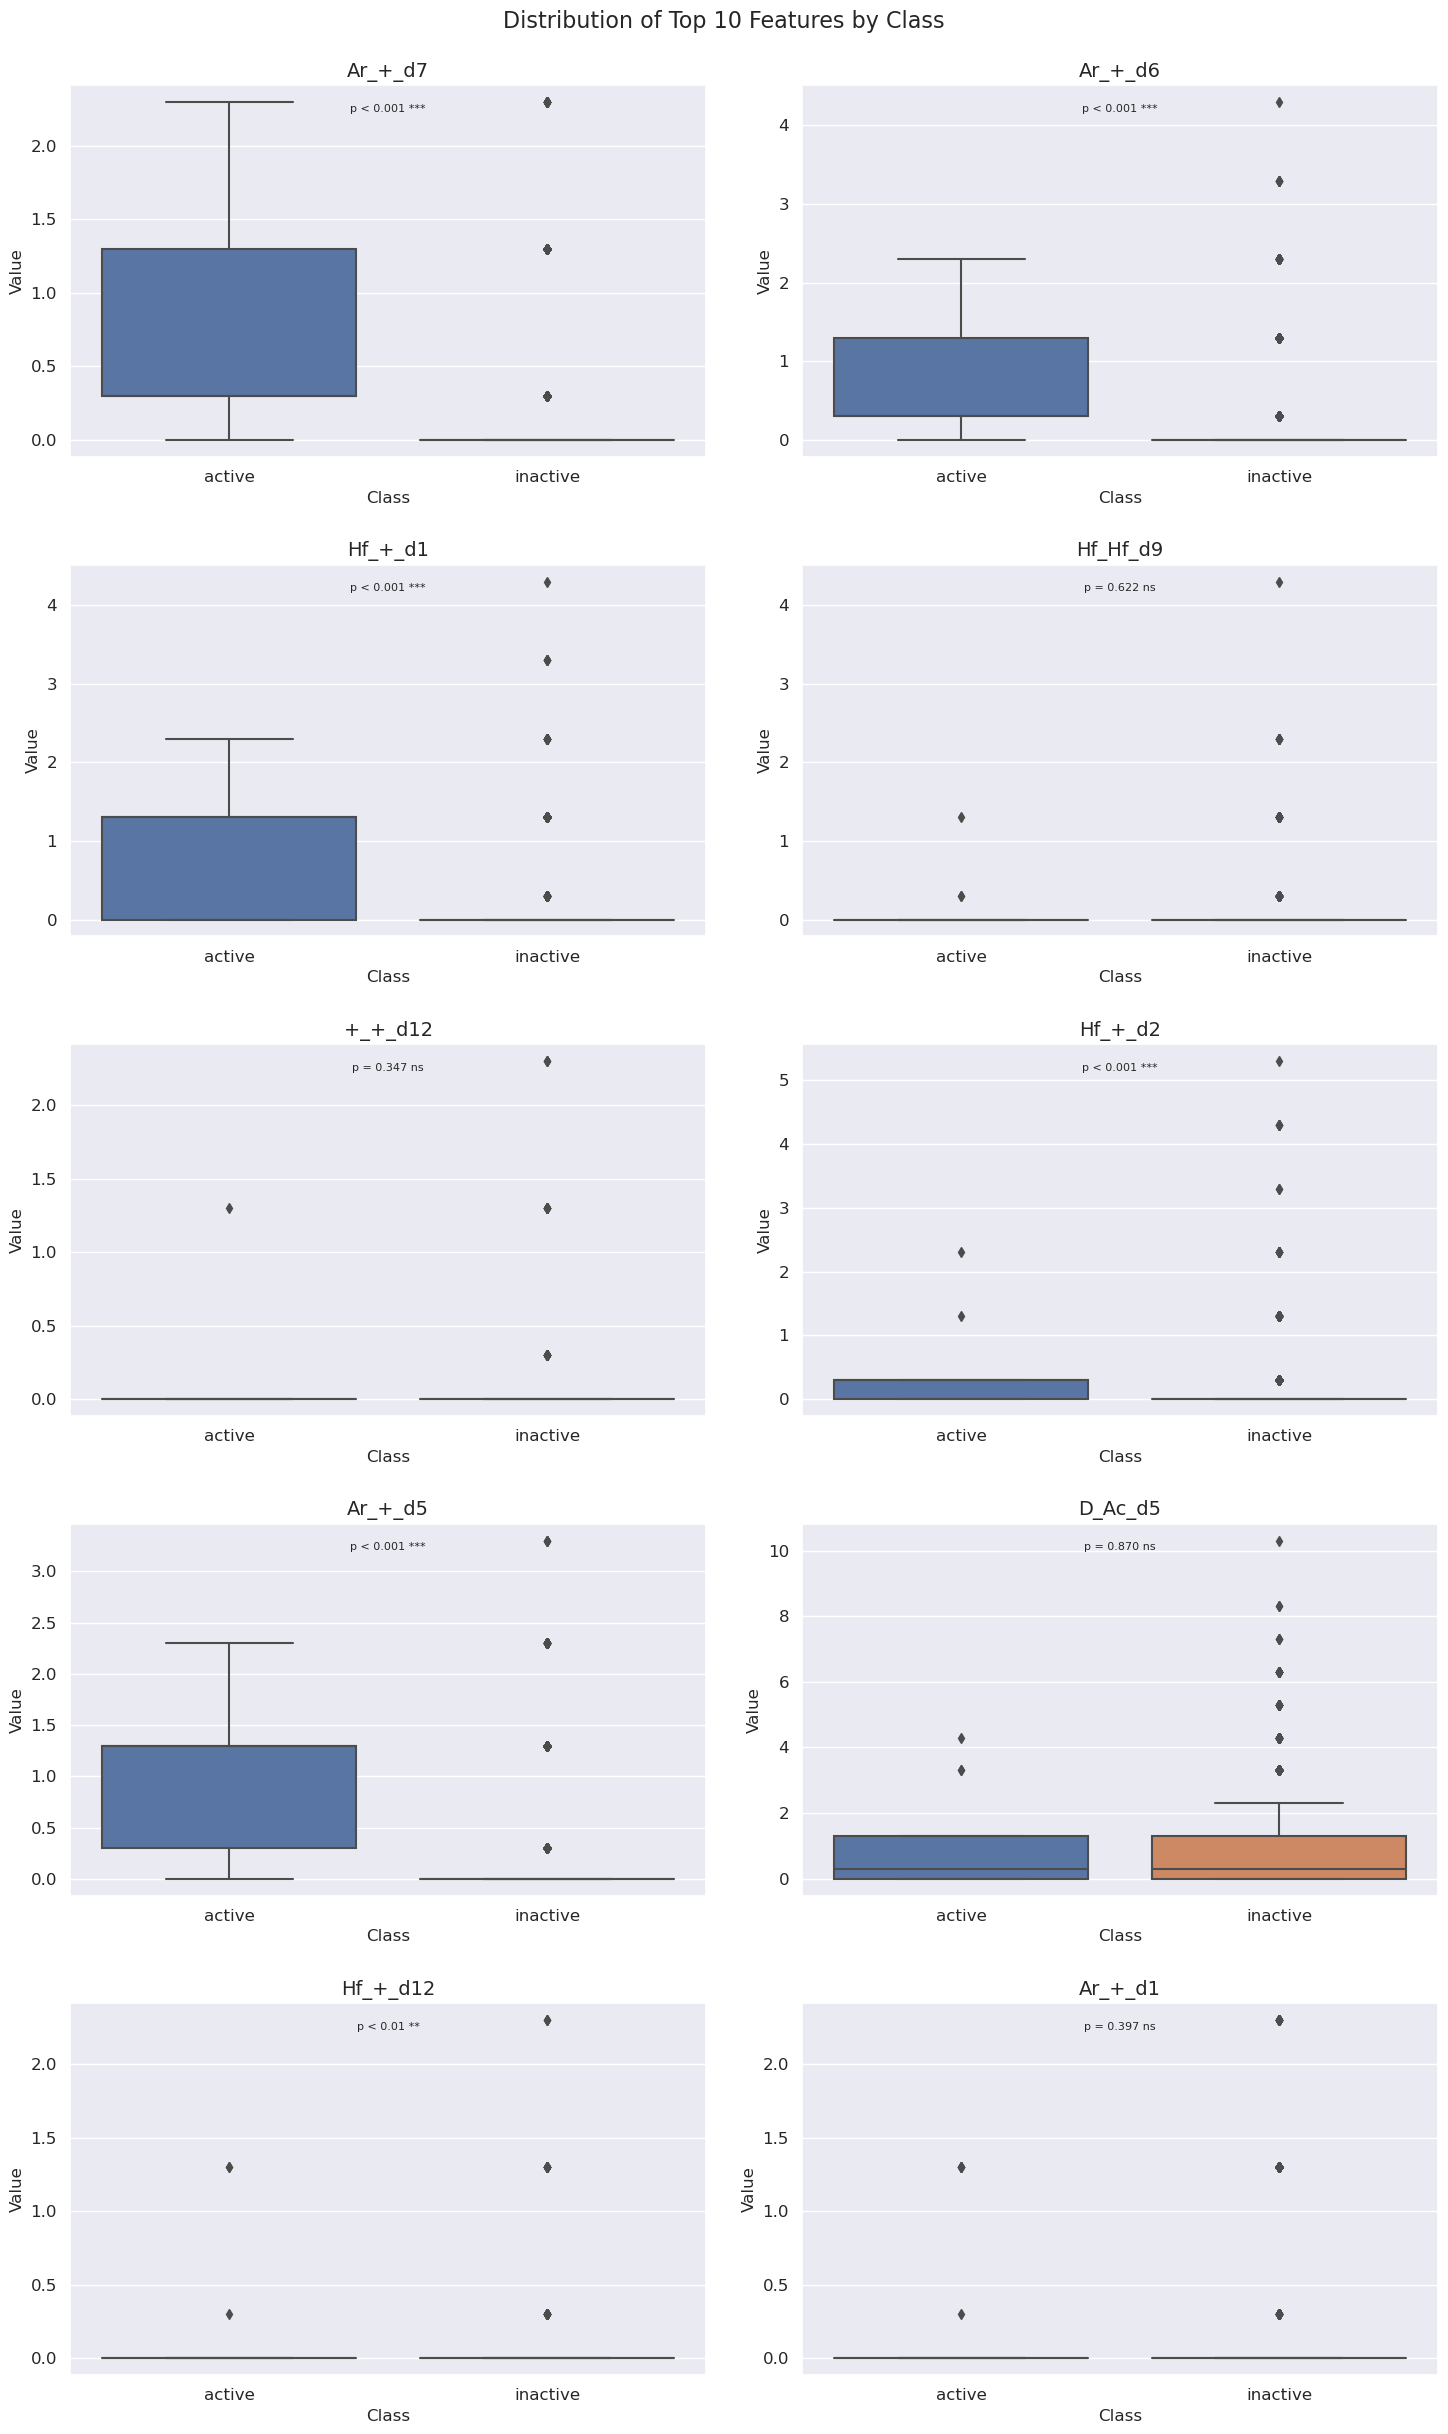

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def clean_and_convert(series):
    return pd.to_numeric(series.replace({'': np.nan, ' ': np.nan}, regex=True), errors='coerce')

def add_significance(ax, data, feature, class_col='Label'):
    classes = data[class_col].unique()
    
    try:
        group1 = data[data[class_col] == classes[0]][feature].dropna()
        group2 = data[data[class_col] == classes[1]][feature].dropna()
        
        if len(group1) > 0 and len(group2) > 0:
            stat, p = stats.mannwhitneyu(group1, group2)
            
            # Add significance indicator
            if p < 0.001:
                text = f'p < 0.001 ***'
            elif p < 0.01:
                text = f'p < 0.01 **'
            elif p < 0.05:
                text = f'p < 0.05 *'
            else:
                text = f'p = {p:.3f} ns'
            
            # Add text to the plot with smaller font size and adjusted position
            ax.text(0.5, 0.95, text, ha='center', va='top', transform=ax.transAxes, fontsize=8)
    except Exception as e:
        print(f"Error in add_significance for {feature}: {str(e)}")

# Set up the plot with increased spacing between subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Distribution of Top 10 Features by Class', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Increase spacing between subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create a boxplot for each feature
for i, col in enumerate(top10cols):
    try:
        #print(f"\nProcessing column: {col}")
        sns.boxplot(x='Label', y=col, data=initial_df2, ax=axes[i])
        axes[i].set_title(col, fontsize=14)
        axes[i].set_xlabel('Class', fontsize=12)
        axes[i].set_ylabel('Value', fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        
        # Add significance indicators
        add_significance(axes[i], initial_df2, col)
    except Exception as e:
        print(f"Error plotting {col}: {str(e)}")
        axes[i].text(0.5, 0.5, f"Error plotting {col}", ha='center', va='center')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Save the figure as SVG
plt.savefig('top10_features_boxplots_with_significance.svg', format='svg', dpi=600, bbox_inches='tight')

